I built an airline predictor in 2019 as a part of analytics Indian magazine's competition.
The goal of the project was to build a high efficiency model to predict airline prices given certain features.
I spent the first two days of the competition understanding how airline tickets are priced. Post this I explored the underlying data set, identified possible features that could potentially be extracted from this data set (feature generation), and implemented a stacked regressor.

I stood first amongst 300+ participants and was invited to their annual forum in Mumbai to be felicitated.

# AIRPRICE PREDICTION - Approach

The approach taken in the modelling of airplane price prediction is as follows:

1) Data exploration: 
    I familiarized myself with the train and test data set. This included understanding the number of rows and columns of train and test data, the type of data in each column, the identification of missing values if any, finding out the value distribution of columns, and finally understanding variation of price with individual columns using visualization.
   
2) Data treatment and Feature Generation:
    After a thorough EDA that helped me familiarize myself with the train and test data set, I decided to coalesce the two data sets to fix some common data issues. For eg: I noted that arrival_time column had an incorrect date value whenever the flight travelled from one date into another- I decided to fix this by adding duration to the departure date time to get the correct arrival date time. I will talk about these more in detail at the time of coding for better understanding.
    
3) Target variable Normalization:
    As noted in most regression models, the models fit better when the target variable is normalized. I used the seaborn package to develop a distribution plot and scipy to develop a probability plot to understand the price distribution in the data. I found the data to have a little right skew with ireegularities and found that the logarithmic function helps me normalize data to a certain extent. 

    Please note, I do not believe this was the best treatment for normalizing pricing, however, I chose to go with it after trying some other normalization methods that didnt give a better output than log, but I am certain there might be a better value treatment I currently havent discovered.
    
4) Null Value Treatment:
    I identified only two missing values overall which were in the columns route and total_stops. On exloring a little further I found both the values to be missing in the same row. I did some digging into the data by filtering other columns that had the same value as the row with missing values. For instance, I filtered the data for all rows having the following column values:
    Destination - Cochin
    Source - Delhi
    Duration - 1420 min
    Month - 5
    Airline - AirIndia
 The idea behind this filtering was that a flight flying between the same source and destination, having the same duration and carrier in the same month will have a similiar route. (This was a hypothesis vaguely based on a paper I read on flight scheduling)
 I found a few other flights with the same column values that had the same route and total stops validating my hypothesis. I replicated the same values for my missing row.
 
5) Outlier Treatment:
    Post missing value treatment I moved further to remove any outliers in my data. I used two models seperately namely ElasticNet and Ridge to fit my training data's dependent and independent variables. I then calculated residuals of both the fits individually. I then calculated Z value of each point by subtracting individual residual values with the mean residual value and then dividing it by the standard deviation of residual value. Any Z value greater than 3 standard deviation of the Z values was considered an outlier for that model. The outlier rows common to both the models were considered as outliers of my main model. 
    
    Please note, using this technique I saw my score drop rather than increase so I decided to not use it as a part of my code. I have only explained this as it was a part of my thought process for solving the problem. I have left the code in comments below for reference.

6) Skew Treatment:
    I used boxcox transformation to treat the skewness of my independent variables to help better fit my model. I learnt this following technique from learning material on Kaggle.
    
7) Modeling:
    I built a stack regressor that uses LightGBM regressor, GradientBoosting regressor, SVR , Random Forest regressor, and Kernel ridge as base models and XGboost regressor as my meta model. The process was to first select individual models and hyperparameter tune them using GridSearchCV (with assistance from articles on analytics vidhya), then check the root mean squared value using a function 'rmsle_cv' that I developed. This function uses the KFold technique for cross validation that helps prevent overfitting on the train data.
  Once all the models were hyperparameter tuned and the individual RMSE scores were satisfactory I stacked them for my final price output.
  
Please Note:

    The code was run iteratively and a lot of things I did to reach this particular section have been removed during the process for simple understanding. For example, GridSearchCV was used for parameter tuning but was removed once the paramaters were tuned satisfactorily. Similiarly, null value treatment consisted of several group by's and column filtering before I finally reached at the column values mentioned above, but have since been removed. 

    Most of the data treatment, feature generation, skew treatment was a part of an iterative process that were edited/omitted/added on the bases of how they scored on the leaderboard. So there is no smooth top down approach to coding that I took, however, I have tried to keep it as clean as possible.

    Outlier treatment was removed from the model but has been commented in the code for understanding
    
    Other models I tried- Lasso, Ridge, Elasticnet , Keras Neural Network regressor, Cat Boost, Blending models.
    

### Importing packages for data processing, feature generation, outlier detection, missing value treatment, skew treatment and modelling

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold
#from sklearn.linear_model import LassoCV , RidgeCV, ElasticNet, Lasso,Ridge
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor  
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import datetime
from mlxtend.regressor import StackingCVRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

/Users/stavyabhatia/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/stavyabhatia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/stavyabhatia/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing 

### Data import and EDA

In [2]:
train=pd.read_excel("Data_Train.xlsx")
test=pd.read_excel("Test_set.xlsx")
sample=pd.read_excel("Sample_submission.xlsx")

In [3]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
Airline            10683 non-null object
Date_of_Journey    10683 non-null object
Source             10683 non-null object
Destination        10683 non-null object
Route              10682 non-null object
Dep_Time           10683 non-null object
Arrival_Time       10683 non-null object
Duration           10683 non-null object
Total_Stops        10682 non-null object
Additional_Info    10683 non-null object
Price              10683 non-null int64
dtypes: int64(1), object(10)
memory usage: 918.1+ KB


,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [5]:
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [6]:
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
Airline            2671 non-null object
Date_of_Journey    2671 non-null object
Source             2671 non-null object
Destination        2671 non-null object
Route              2671 non-null object
Dep_Time           2671 non-null object
Arrival_Time       2671 non-null object
Duration           2671 non-null object
Total_Stops        2671 non-null object
Additional_Info    2671 non-null object
dtypes: object(10)
memory usage: 208.8+ KB


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671
unique,11,44,5,6,100,199,704,320,5,6
top,Jet Airways,9/05/2019,Delhi,Cochin,DEL → BOM → COK,10:00,19:00,2h 50m,1 stop,No info
freq,897,144,1145,1145,624,62,113,122,1431,2148


In [7]:
# storing number of rows as an a variable for later use
len_train=train.shape[0]

In [8]:
#coalescing the two columns for data treatment
train=train.append(test)
train=train.reset_index()
train=train.drop('index',axis=1)

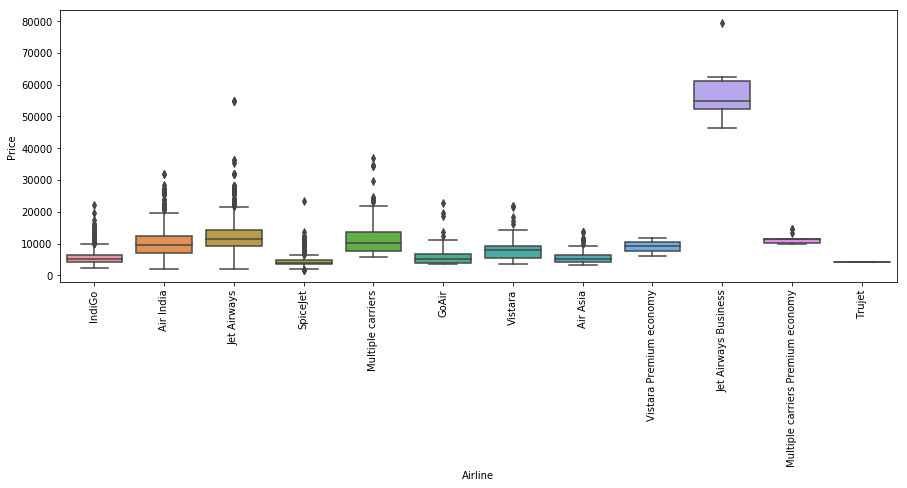

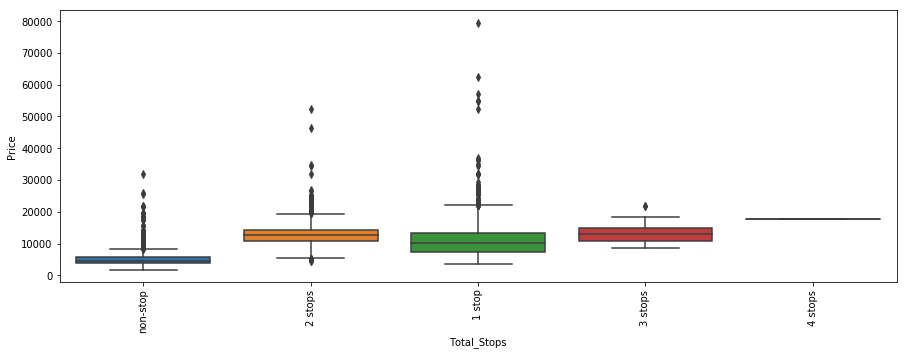

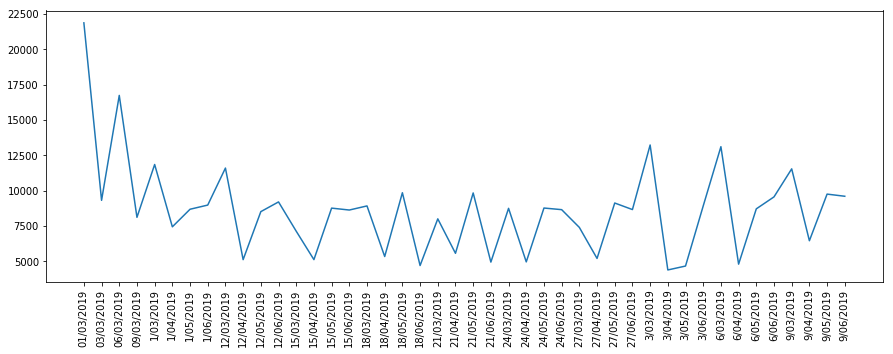

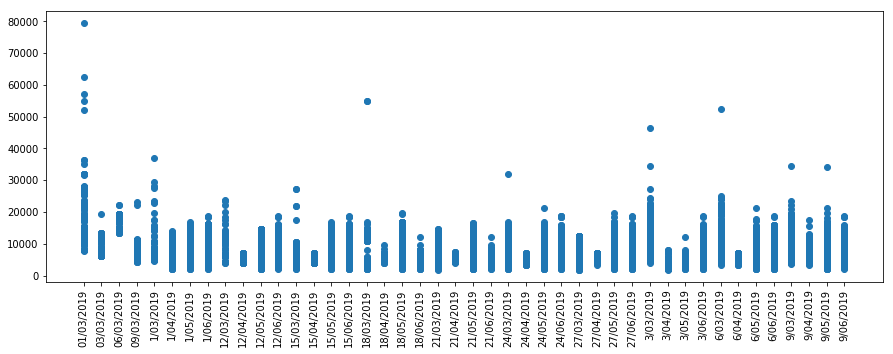

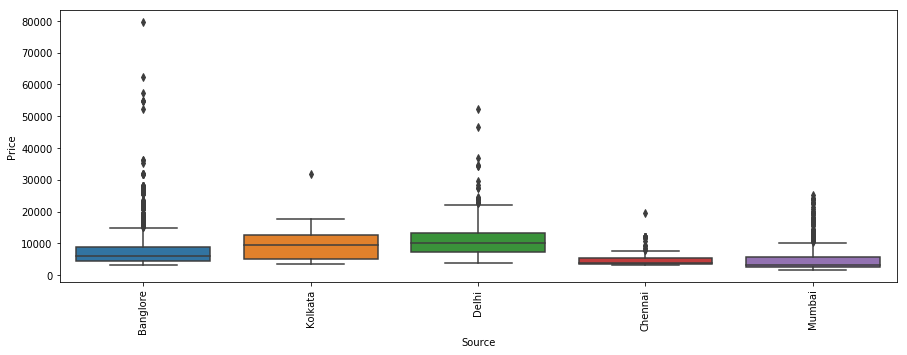

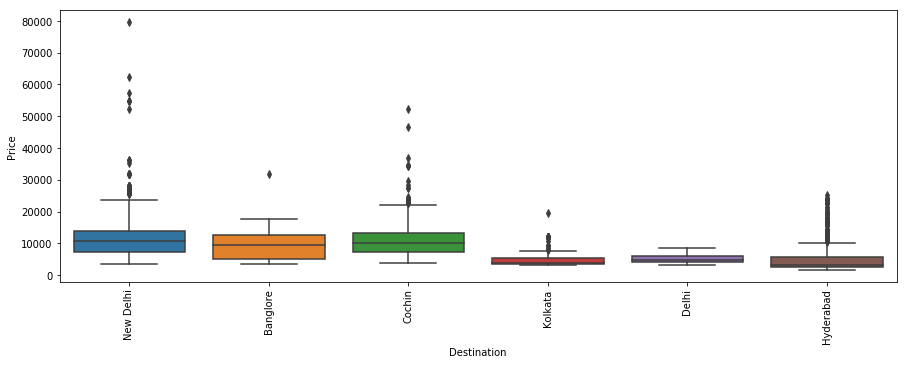

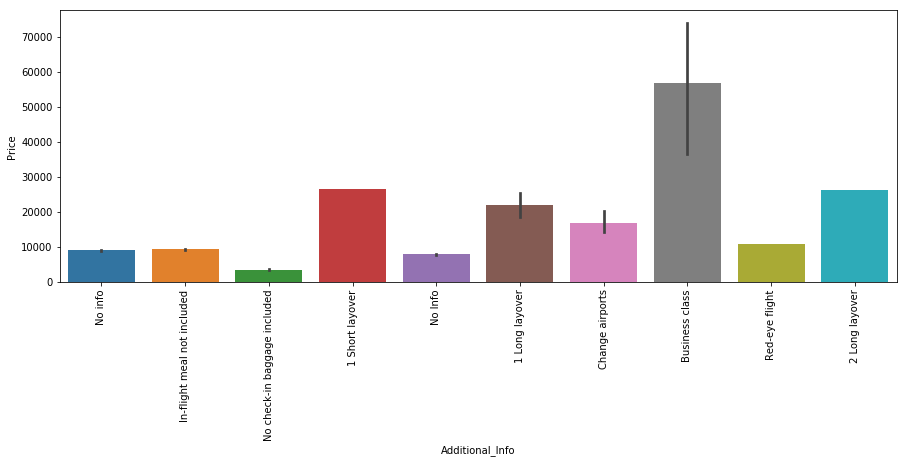

In [9]:
#Visually understanding the variation of price with different columns
plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.boxplot(train.Airline, train.Price)

plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.boxplot(train.Total_Stops, train.Price)

plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
plt.plot(train.sort_values(['Date_of_Journey']).Date_of_Journey.unique(), train.groupby(['Date_of_Journey']).mean())

plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
plt.scatter(train.Date_of_Journey, train.Price)

plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.boxplot(train.Source, train.Price )

plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.boxplot(train.Destination, train.Price )

plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.barplot(train.Additional_Info, train.Price )

### Data Treatment and Feature Generation

In [10]:
"""train['Depart_Time_Hour'] = pd.to_datetime(train.Dep_Time).dt.hour
train['Depart_Time_Minutes'] = pd.to_datetime(train.Dep_Time).dt.minute

train['Arr_Time_Hour'] = pd.to_datetime(train.Arrival_Time).dt.hour
train['Arr_Time_Minutes'] = pd.to_datetime(train.Arrival_Time).dt.minute"""

"train['Depart_Time_Hour'] = pd.to_datetime(train.Dep_Time).dt.hour\ntrain['Depart_Time_Minutes'] = pd.to_datetime(train.Dep_Time).dt.minute\n\ntrain['Arr_Time_Hour'] = pd.to_datetime(train.Arrival_Time).dt.hour\ntrain['Arr_Time_Minutes'] = pd.to_datetime(train.Arrival_Time).dt.minute"

In [11]:
# Converting Dep_Time from object (string) to time format
train.Dep_Time=pd.to_datetime(train.Dep_Time, format= '%H:%M').dt.time

In [12]:
# String manipulation to extract only hours and minutes from arrival_time column and dropping the date part, then 
# converting the string to time format as done above
train.Arrival_Time=train.Arrival_Time.str.slice(0,6)
train.Arrival_Time=train.Arrival_Time.str.strip()
train.Arrival_Time=pd.to_datetime(train.Arrival_Time, format = '%H:%M').dt.time

In [13]:
# Converting date of journey to date format
train.Date_of_Journey=pd.to_datetime(train.Date_of_Journey,format='%d/%m/%Y').dt.date

In [14]:
# Converting duration from string to integer value in minutes
minute=train['Duration'].str.slice(3,).str.extract('(\d+)')
hour=train['Duration'].str.extract('(\d+)').astype('int')
minute=minute.fillna(0) #filling up minute= 0 where the flight duration only had hours
train['Duration']=minute.astype('int')+hour*60

/Users/stavyabhatia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/Users/stavyabhatia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Creating column date of arrival by adding date and time of journey with duration in minutes
train['Date_of_Arrival']=train.apply(lambda r : pd.datetime.combine(r['Date_of_Journey'],r['Dep_Time']),1) + pd.to_timedelta(train.Duration,unit='m')
train['Date_of_Arrival']=train.Date_of_Arrival.dt.date

In [16]:
# Changing Total Stops from a string value to a categorical value 
train.Total_Stops.value_counts()

1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

In [17]:
dic={'non-stop':0,'2 stops':2,'1 stop':1,'3 stops':3,'4 stops': 4}
train['Total_Stops']=train.Total_Stops.map(dic)
train.Total_Stops=train.Total_Stops.astype('category')

In [18]:
# Creating a column a categorical column class from the column Airline 
r=train.Airline.str.split(' ',expand=True).get(2)
d={None:'Economy','Premium': 'Premium Economy','economy':'Premium Economy','Business':'Business' }
r=r.map(d)
train['Class']=r
train.Class=train.Class.astype('category')

In [19]:
# The column Additional info had values No info and No Info stored, editing to bring them to the same string value
train.loc[train.Additional_Info=="No info",'Additional_Info']="No Info"

In [20]:
# Creating an integer column same_day_travel that highlights whether the flight was arrived the same day, a day from dep, or more..
train['Same_day_travel']=train.Date_of_Arrival-train.Date_of_Journey
train['Same_day_travel']=train.Same_day_travel.astype('category')

In [21]:
# Converting Airline to category as price varies with airlines ( Category column helps in tree based modelling)
train.Airline=train.Airline.astype('category')

In [22]:
# Creating 2 columns weekday journey and weekday arrival that highligh what day of the week the flight took off and arrived
# respectively. The idea is that the price will be marginally higher on weekends and this metric can help catch that.
train['weekday_journey']=train['Date_of_Journey'].apply(lambda x: x.weekday())
train['weekday_arrival']=train['Date_of_Arrival'].apply(lambda x: x.weekday())

In [23]:
# Creating columns for year, month, and day of both departure and arrival as integers to be able to better 
# capture any seasonality due to date
train['Year']=pd.DatetimeIndex(train['Date_of_Journey']).year
train['month_of_journey']=pd.DatetimeIndex(train['Date_of_Journey']).month
train['month_of_Arrival']=pd.DatetimeIndex(train['Date_of_Arrival']).month
train['day_of_Arrival']=pd.DatetimeIndex(train['Date_of_Arrival']).day
train['day_of_journey']=pd.DatetimeIndex(train['Date_of_Journey']).day

In [24]:
# Seeing the number of columns generated - (11 more columns were created in the process)
train.shape

(13354, 21)

In [25]:
# Techniques that I tried but didnt help - Number of take offs and landings in a day 
# - Number of takeoffs by city and landings by city in a day
"""r=train.groupby(['Date_of_Journey']).Date_of_Journey.apply(lambda x: x.count())
train['Number_take-offs']=train.Date_of_Journey.map(r)
r=train.groupby(['Date_of_Arrival']).Date_of_Arrival.apply(lambda x: x.count())
train['Number_landings']=train.Date_of_Arrival.map(r)
"""

"r=train.groupby(['Date_of_Journey']).Date_of_Journey.apply(lambda x: x.count())\ntrain['Number_take-offs']=train.Date_of_Journey.map(r)\nr=train.groupby(['Date_of_Arrival']).Date_of_Arrival.apply(lambda x: x.count())\ntrain['Number_landings']=train.Date_of_Arrival.map(r)\n"

In [26]:
"""r=train.groupby(['Date_of_Journey','Source'])['Source'].count().reset_index(name='Number_takeoff_source')
train=train.merge(r,how="left", on=["Date_of_Journey","Source"])
r=train.groupby(['Date_of_Arrival','Source'])['Source'].count().reset_index(name='Number_landing_Destination')
train=train.merge(r,how="left", on=["Date_of_Arrival","Source"])
"""

'r=train.groupby([\'Date_of_Journey\',\'Source\'])[\'Source\'].count().reset_index(name=\'Number_takeoff_source\')\ntrain=train.merge(r,how="left", on=["Date_of_Journey","Source"])\nr=train.groupby([\'Date_of_Arrival\',\'Source\'])[\'Source\'].count().reset_index(name=\'Number_landing_Destination\')\ntrain=train.merge(r,how="left", on=["Date_of_Arrival","Source"])\n'

In [27]:
#train[(train.Date_of_Arrival==datetime.date(2019,3,1))][['Source','Number_landing_Destination']]

In [28]:
"""plt.subplots(figsize=(12,15))
sns.boxplot(train[train.Source=='Delhi'].sort_values(['Date_of_Journey']).Number_takeoff_source,train[train.Source=='Delhi'].sort_values(['Date_of_Journey']).Price)
plt.xticks(rotation=90)"""

"plt.subplots(figsize=(12,15))\nsns.boxplot(train[train.Source=='Delhi'].sort_values(['Date_of_Journey']).Number_takeoff_source,train[train.Source=='Delhi'].sort_values(['Date_of_Journey']).Price)\nplt.xticks(rotation=90)"

### Target Variable Normalization

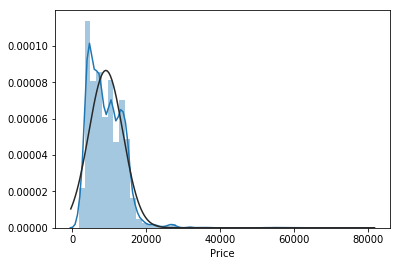

((array([-3.82690953, -3.60266143, -3.4795895 , ...,  3.4795895 ,
          3.60266143,  3.82690953]),
  array([ 1759.,  1759.,  1759., ..., 57209., 62427., 79512.])),
 (4364.062692425855, 9087.064120565383, 0.9460976378917301))

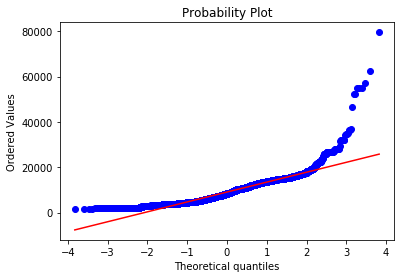

In [29]:
sns.distplot(train[:len_train].Price, fit=stats.norm)
l=plt.show()
stats.probplot(train[:len_train].Price,plot=plt )

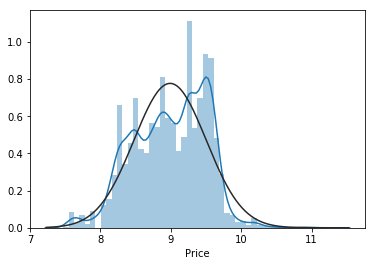

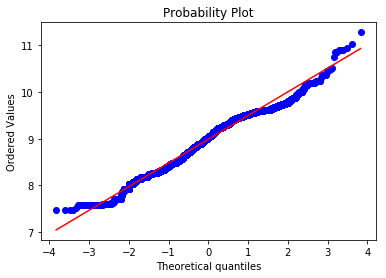

In [30]:
xt=np.log(train[:len_train].Price)
sns.distplot(xt, fit=stats.norm)
l=plt.show()
stats.probplot(xt,plot=plt )

train.Price=np.log(train.Price)

### Null Value Treatment

In [31]:
##Identifying columns with missing values
train.isnull().sum()

Additional_Info        0
Airline                0
Arrival_Time           0
Date_of_Journey        0
Dep_Time               0
Destination            0
Duration               0
Price               2671
Route                  1
Source                 0
Total_Stops            1
Date_of_Arrival        0
Class                  0
Same_day_travel        0
weekday_journey        0
weekday_arrival        0
Year                   0
month_of_journey       0
month_of_Arrival       0
day_of_Arrival         0
day_of_journey         0
dtype: int64

In [32]:
# Filtering data with missing value and filling up with appropriate values as determined
train.loc[(train.Source=='Delhi') & (train.Destination=='Cochin') & (pd.DatetimeIndex(train['Date_of_Journey']).month==5)& (train.Duration==1420) &(train.Airline=='Air India') ].sort_values(['Date_of_Journey'])


,Additional_Info,Airline,Arrival_Time,Date_of_Journey,Dep_Time,Destination,Duration,Price,Route,Source,...,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year,month_of_journey,month_of_Arrival,day_of_Arrival,day_of_journey
9039,No Info,Air India,09:25:00,2019-05-06,09:45:00,Cochin,1420,8.919988,NaN,Delhi,...,2019-05-07,Economy,1 days,0,1,2019,5,5,7,6
10348,No Info,Air India,09:25:00,2019-05-09,09:45:00,Cochin,1420,9.202812,DEL → HYD → MAA → COK,Delhi,...,2019-05-10,Economy,1 days,3,4,2019,5,5,10,9
12318,No Info,Air India,09:25:00,2019-05-09,09:45:00,Cochin,1420,NaN,DEL → MAA → COK,Delhi,...,2019-05-10,Economy,1 days,3,4,2019,5,5,10,9
2343,No Info,Air India,09:25:00,2019-05-15,09:45:00,Cochin,1420,9.303375,DEL → HYD → MAA → COK,Delhi,...,2019-05-16,Economy,1 days,2,3,2019,5,5,16,15
2554,No Info,Air India,09:25:00,2019-05-15,09:45:00,Cochin,1420,8.919988,DEL → MAA → COK,Delhi,...,2019-05-16,Economy,1 days,2,3,2019,5,5,16,15
3595,No Info,Air India,09:25:00,2019-05-18,09:45:00,Cochin,1420,9.032648,DEL → MAA → COK,Delhi,...,2019-05-19,Economy,1 days,5,6,2019,5,5,19,18
9717,No Info,Air India,09:25:00,2019-05-18,09:45:00,Cochin,1420,9.303375,DEL → HYD → MAA → COK,Delhi,...,2019-05-19,Economy,1 days,5,6,2019,5,5,19,18
8135,No Info,Air India,09:25:00,2019-05-21,09:45:00,Cochin,1420,9.303375,DEL → HYD → MAA → COK,Delhi,...,2019-05-22,Economy,1 days,1,2,2019,5,5,22,21
1616,No Info,Air India,09:25:00,2019-05-24,09:45:00,Cochin,1420,8.919988,DEL → MAA → COK,Delhi,...,2019-05-25,Economy,1 days,4,5,2019,5,5,25,24


In [33]:
train.Route=train.Route.fillna('DEL → MAA → COK')
train.loc[train.Total_Stops.isnull(),'Total_Stops']=1

### Outlier Treatment- Did not Use for modelling

In [34]:
"""#Outlier Treatment
x_out=pd.get_dummies(train[:len_train].drop('Price',axis=1))
y_out=train[:len_train].Price

enet= ElasticNet(max_iter=1000,alpha=0.001,l1_ratio=0)

enet.fit(x_out,y_out)
y_pred=enet.predict(x_out)
resid=y_out-y_pred
z=(resid-resid.mean())/resid.std()
z=np.array(z)
outlier=np.where(abs(z)>abs(z).std()*5)[0]

plt.figure(figsize=(6, 6))
plt.scatter(y_out, y_pred)
plt.scatter(y_out.iloc[outlier], y_pred[outlier])
plt.plot(range(7, 12), range(7, 12), color="red")"""

'#Outlier Treatment\nx_out=pd.get_dummies(train[:len_train].drop(\'Price\',axis=1))\ny_out=train[:len_train].Price\n\nenet= ElasticNet(max_iter=1000,alpha=0.001,l1_ratio=0)\n\nenet.fit(x_out,y_out)\ny_pred=enet.predict(x_out)\nresid=y_out-y_pred\nz=(resid-resid.mean())/resid.std()\nz=np.array(z)\noutlier=np.where(abs(z)>abs(z).std()*5)[0]\n\nplt.figure(figsize=(6, 6))\nplt.scatter(y_out, y_pred)\nplt.scatter(y_out.iloc[outlier], y_pred[outlier])\nplt.plot(range(7, 12), range(7, 12), color="red")'

In [35]:
"""ridge=Ridge(alpha=1)

ridge.fit(x_out,y_out)
y_pred=ridge.predict(x_out)
resid=y_out-y_pred
z=(resid-resid.mean())/resid.std()
z=np.array(z)
outlier2=np.where(abs(z)>abs(z).std()*5)[0]
len(outlier2)

plt.figure(figsize=(6, 6))
plt.scatter(y_out, y_pred)
plt.scatter(y_out.iloc[outlier2], y_pred[outlier2])
plt.plot(range(7, 12), range(7, 12), color="red")"""

'ridge=Ridge(alpha=1)\n\nridge.fit(x_out,y_out)\ny_pred=ridge.predict(x_out)\nresid=y_out-y_pred\nz=(resid-resid.mean())/resid.std()\nz=np.array(z)\noutlier2=np.where(abs(z)>abs(z).std()*5)[0]\nlen(outlier2)\n\nplt.figure(figsize=(6, 6))\nplt.scatter(y_out, y_pred)\nplt.scatter(y_out.iloc[outlier2], y_pred[outlier2])\nplt.plot(range(7, 12), range(7, 12), color="red")'

In [36]:
"""outlier_final=[]
for i in outlier:
    for j in outlier2:
        if i==j:
            outlier_final.append(i)
(outlier_final)"""

'outlier_final=[]\nfor i in outlier:\n    for j in outlier2:\n        if i==j:\n            outlier_final.append(i)\n(outlier_final)'

In [37]:
train.head()

,Additional_Info,Airline,Arrival_Time,Date_of_Journey,Dep_Time,Destination,Duration,Price,Route,Source,...,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year,month_of_journey,month_of_Arrival,day_of_Arrival,day_of_journey
0,No Info,IndiGo,01:10:00,2019-03-24,22:20:00,New Delhi,170,8.267962,BLR → DEL,Banglore,...,2019-03-25,Economy,1 days,6,0,2019,3,3,25,24
1,No Info,Air India,13:15:00,2019-05-01,05:50:00,Banglore,445,8.944028,CCU → IXR → BBI → BLR,Kolkata,...,2019-05-01,Economy,0 days,2,2,2019,5,5,1,1
2,No Info,Jet Airways,04:25:00,2019-06-09,09:25:00,Cochin,1140,9.538348,DEL → LKO → BOM → COK,Delhi,...,2019-06-10,Economy,1 days,6,0,2019,6,6,10,9
3,No Info,IndiGo,23:30:00,2019-05-12,18:05:00,Banglore,325,8.735204,CCU → NAG → BLR,Kolkata,...,2019-05-12,Economy,0 days,6,6,2019,5,5,12,12
4,No Info,IndiGo,21:35:00,2019-03-01,16:50:00,New Delhi,285,9.495670,BLR → NAG → DEL,Banglore,...,2019-03-01,Economy,0 days,4,4,2019,3,3,1,1


### Skew Treatment (BOXCOX Transform)

In [38]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in train.columns:
    if i!='Price':
        if train[i].dtype in numeric_dtypes: 
            numerics2.append(i)

skew_features = train[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
print(skews)

high_skew = skew_features[abs(skew_features) > 0.3]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
     if i!='=Price':
        train[i]= boxcox1p(train[i], boxcox_normmax(train[i]+1))

        
skew_features2 = train[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2


                      skew
Duration          0.867995
day_of_journey    0.135127
day_of_Arrival    0.132062
weekday_journey   0.040376
weekday_arrival   0.030020
Year              0.000000
month_of_Arrival -0.390640
month_of_journey -0.390640


,skew
day_of_journey,0.135127
day_of_Arrival,0.132062
Duration,0.054899
weekday_journey,0.040376
weekday_arrival,0.030020
Year,0.000000
month_of_Arrival,-0.105846
month_of_journey,-0.105846


### Data preperation for Modelling and Modelling

In [39]:
# Creating a sparse matrix using pandas get dummies function that helps split string columns into boolean values.
df=pd.get_dummies(train)

In [40]:
# Splitting test and train data
train_df=df[:len_train]
test_df=df[len_train:]

In [41]:
# Removing Price from independent variable data and keeping only price in the other
x=train_df.drop('Price',axis=1)
y=train_df['Price']

In [42]:
#model training 

In [43]:
# Writing a function to evaluate model performance using KFOLD and cross validation
def rmsle_cv(model):
    kfold=KFold(n_splits=2, shuffle=True, random_state=10).get_n_splits(x)
    rmse=np.sqrt(-cross_val_score(model,x,y,cv=kfold, scoring='neg_mean_squared_error'))
    return rmse

In [44]:
# All paramaters used in the models have been tuned using the GRIDSEARCHCV funtion on the basis of articles on 
# Analytics Vidhya

In [45]:
lightgbm=LGBMRegressor(objective='regression',num_leaves=80,
                              learning_rate=0.1, n_estimators=1200,
                              max_bin = 30, bagging_fraction = 0.8,
                              bagging_freq = 9, feature_fraction = 0.129,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =3, min_sum_hessian_in_leaf = 6, random_state=10)

In [46]:
#rmsle_cv(lightgbm).mean(),rmsle_cv(lightgbm).std() # Commented for faster running of complete code

In [47]:
xgb=XGBRegressor(learning_rate =0.1, 
      n_estimators=1500, max_depth=12, min_child_weight=1,gamma=0, reg_alpha=2e-5,
      subsample=0.8,colsample_bytree=0.8,
      nthread=4,scale_pos_weight=1,seed=27,verbose=True,random_state=10)

In [48]:
#rmsle_cv(xgb).mean(),rmsle_cv(xgb).std() # Commented for faster running of complete code

In [49]:
grb=GradientBoostingRegressor(learning_rate=0.1,n_estimators=400, max_depth=12
                              ,subsample=0.8,
                              verbose=False,random_state=10)

In [50]:
#rmsle_cv(grb).mean(), rmsle_cv(grb).std() # Commented for faster running of complete code

In [51]:
svr = Pipeline([('Scaler',RobustScaler()), ('SVR',SVR(C= 10000, epsilon= 0.008, gamma=0.009))])

In [52]:
#rmsle_cv(svr).mean(), rmsle_cv(svr).std() # Commented for faster running of complete code

In [53]:
krr=KernelRidge(alpha=1, kernel='polynomial', gamma=0.001,degree=3,coef0=5)
#rmsle_cv(krr).mean(), rmsle_cv(krr).std() # Commented for faster running of complete code

In [54]:
rf=RandomForestRegressor(n_estimators=3000, oob_score = False, n_jobs = -1,random_state =50,
                         max_features = "auto", min_samples_leaf = 2,warm_start=True,criterion='mse',max_depth=50)

In [55]:
#rmsle_cv(rf).mean(), rmsle_cv(rf).std() # Commented for faster running of complete code

In [56]:
# Final ensemble that uses outputs from each model regressor and the original data in the meta regressor XGB
avg=StackingCVRegressor(regressors=(lightgbm,grb,svr,krr,rf),meta_regressor=xgb, use_features_in_secondary=True)

In [57]:
# Function to calculate RMSE error of the complete model for reference, similiar to rmsle_cv without KFOLD CV
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [58]:
X=np.array(x)
Y=np.array(y)

In [59]:
# Fitting the model on the train data and predicting the train price values
avg.fit(X,Y)
y_pred=avg.predict(X)

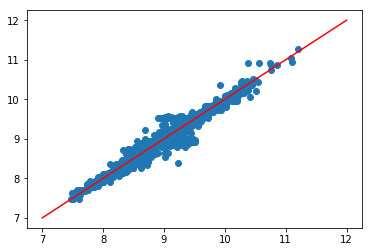

In [60]:
# Plot of the model prediction with the original price values in the training data set to undestand model fit
plt.scatter(list(y_pred),y)
plt.plot(range(7,13),range(7,13),'r')

In [61]:
# RMSE value of the model on training data
rmsle(y,y_pred)

0.05794757027443086

In [62]:
# Predictions of test data
Predict=avg.predict(np.array(test_df.drop('Price',axis=1)))

In [63]:
# Converting price back to original scale and making it integer
Predict=np.exp(Predict)
Predict=Predict.astype(int)

In [64]:
# Converting predicted values to dataframe
Submission=pd.DataFrame(Predict,columns=['Price'])

In [65]:
len(Submission)

2671

In [66]:
Submission.head()

,Price
0,14850
1,4400
2,12945
3,8705
4,3571


In [67]:
# Final Submission
Submission.to_excel('Submission_rf.xlsx')